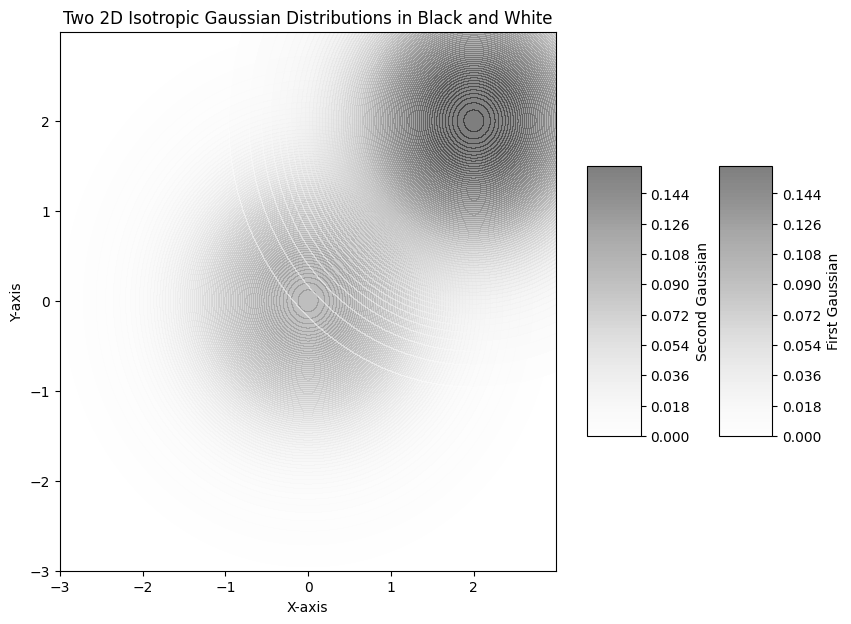

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters for the two isotropic Gaussians
mean1 = [0, 0]  # Mean of the first Gaussian
sigma1 = 1      # Standard deviation for the first Gaussian
covariance_matrix1 = np.array([[sigma1**2, 0], [0, sigma1**2]])  # Covariance matrix for the first Gaussian

mean2 = [2, 2]  # Mean of the second Gaussian
sigma2 = 1    # Standard deviation for the second Gaussian
covariance_matrix2 = np.array([[sigma2**2, 0], [0, sigma2**2]])  # Covariance matrix for the second Gaussian

# Create a grid of (x,y) values
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# Create the isotropic Gaussian distributions
rv1 = multivariate_normal(mean1, covariance_matrix1)
rv2 = multivariate_normal(mean2, covariance_matrix2)

# Plot the distributions with black and white color maps
fig, ax = plt.subplots(figsize=(10, 7))

# Adjust the contour plots to use a black and white colormap ('Greys')
contour1_bw = ax.contourf(x, y, rv1.pdf(pos), levels=100, cmap='Greys', alpha=0.5)
contour2_bw = ax.contourf(x, y, rv2.pdf(pos), levels=100, cmap='Greys', alpha=0.5)

# Add color bars for each contour plot using black and white
fig.colorbar(contour1_bw, ax=ax, shrink=0.5, aspect=5, label='First Gaussian')
fig.colorbar(contour2_bw, ax=ax, shrink=0.5, aspect=5, label='Second Gaussian')

ax.set_title('Two 2D Isotropic Gaussian Distributions in Black and White')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

plt.show()


In [2]:
# Coordinate to evaluate
point = np.array([1, 1])

# Evaluate the PDF of both Gaussians at the specified point
pdf_value1 = rv1.pdf(point)
pdf_value2 = rv2.pdf(point)

# Calculate the combined PDF value by adding them up
combined_pdf_value = pdf_value1 + pdf_value2

print(f"PDF value of the first Gaussian at {point}: {pdf_value1}")
print(f"PDF value of the second Gaussian at {point}: {pdf_value2}")
print(f"Combined PDF value at {point}: {combined_pdf_value}")


PDF value of the first Gaussian at [1 1]: 0.05854983152431917
PDF value of the second Gaussian at [1 1]: 0.05854983152431917
Combined PDF value at [1 1]: 0.11709966304863834


In [3]:
import os
import sys

sys.path.append(os.path.abspath('../'))

from data import get_train_dataloader, get_test_dataloader
from mri import MRI
from nn import NeuralNet, GaussianMapping, PosEncMapping
from utils import get_device

In [4]:
lr_mri_path = '../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_2.nii.gz'
lr_mri = MRI.from_nii_file(lr_mri_path)

12:55:30 | Reading data from ../../../hcp1200/996782/T1w_acpc_dc_restore_brain_downsample_factor_2.nii.gz


12:55:30 | Displaying relevant brain slices


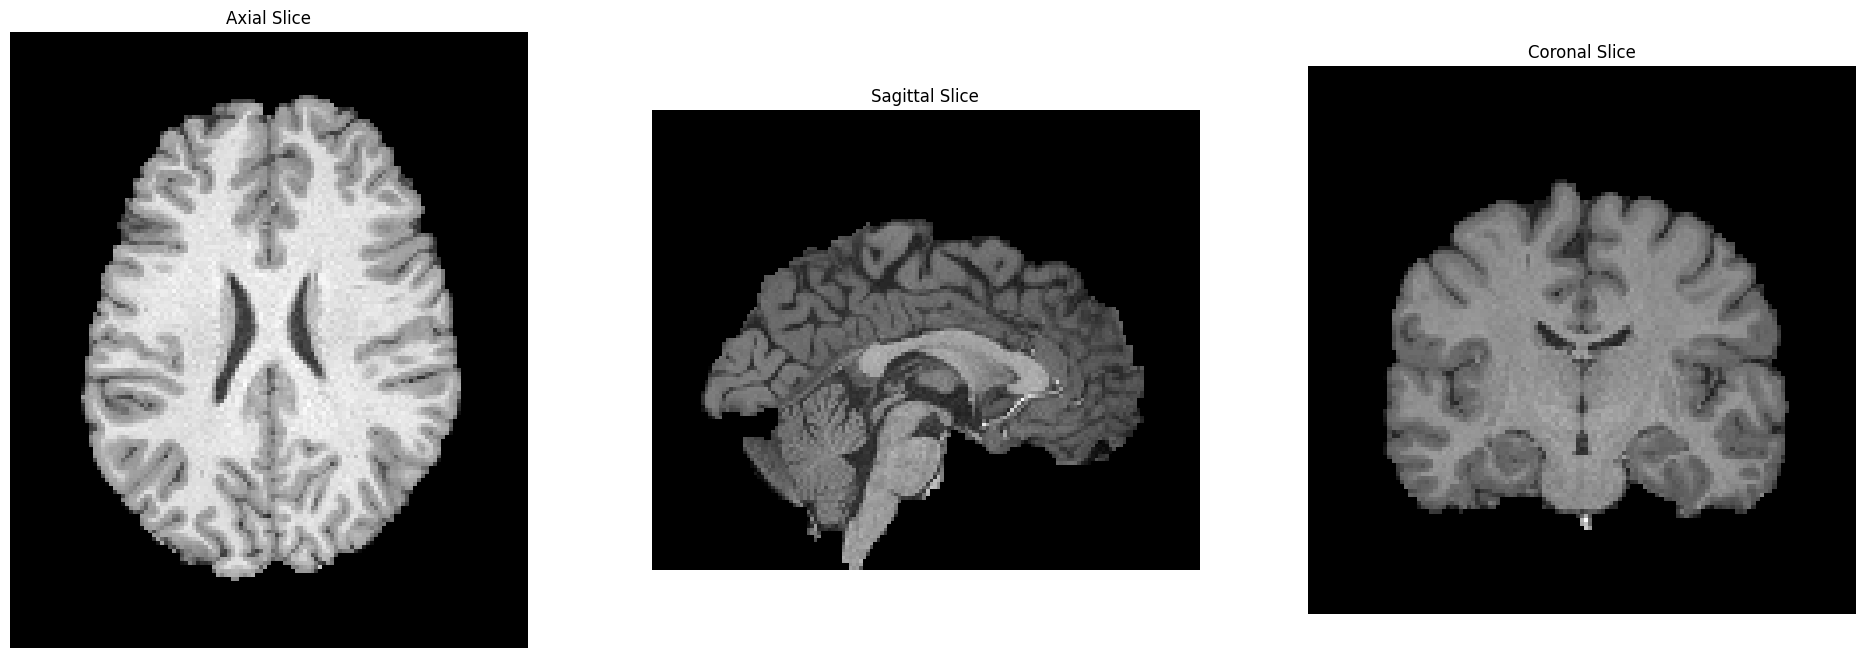

In [5]:
lr_mri.display_relevant_brain_slices()

## Gradients

In [6]:
import numpy as np

# Assuming `mri_volume` is your MRI data as a NumPy array of shape (x, y, z)
mri_volume = lr_mri.data  # Example MRI volume data

# Compute the gradient along each dimension
grad_x, grad_y, grad_z = np.gradient(mri_volume)

# Compute the magnitude of the gradient (norm) at each voxel
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)


### Gradient Magnitude Visualization

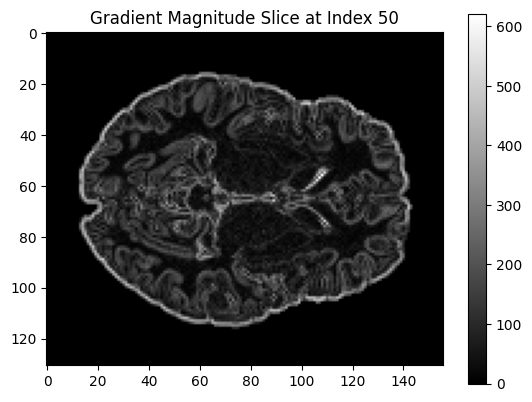

In [7]:
# Assuming grad_magnitude is computed as shown in the previous example
# Select a slice to visualize
slice_index = 50  # Example slice index
plt.imshow(grad_magnitude[:, :, slice_index], cmap='gray')
plt.colorbar()
plt.title(f'Gradient Magnitude Slice at Index {slice_index}')
plt.show()


### Gradient Direction Visualization

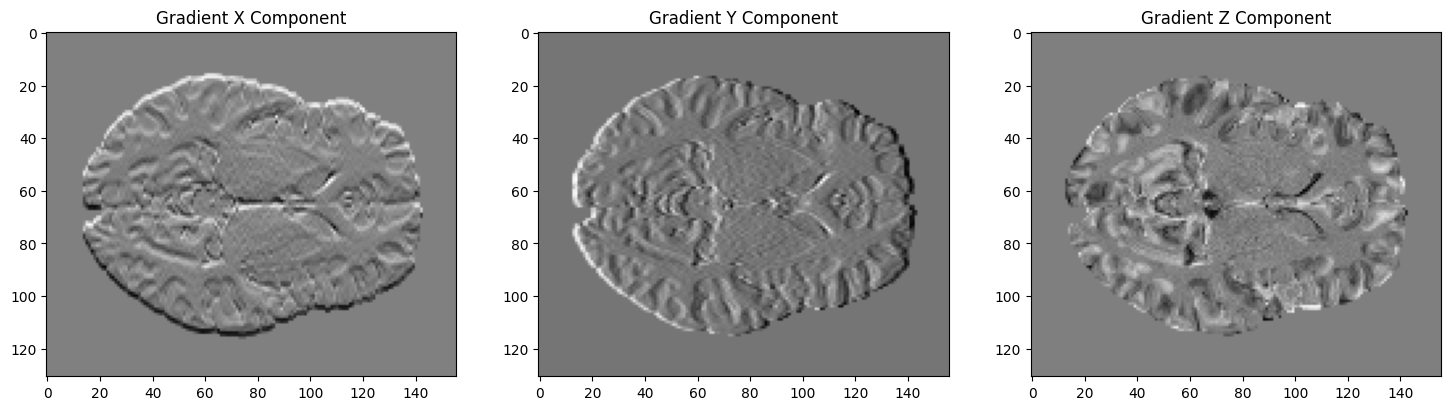

In [8]:
# Choose a slice
slice_index = 50

# Visualize the x, y, and z components of the gradient
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(grad_x[:, :, slice_index], cmap='gray')
axes[0].set_title('Gradient X Component')

axes[1].imshow(grad_y[:, :, slice_index], cmap='gray')
axes[1].set_title('Gradient Y Component')

axes[2].imshow(grad_z[:, :, slice_index], cmap='gray')
axes[2].set_title('Gradient Z Component')

plt.show()


## Initialize Gaussians

In [20]:
import numpy as np
from scipy.ndimage import gaussian_filter

# Assuming mri_volume is your MRI data as a NumPy array of shape (x, y, z)
# Example MRI volume data generation for demonstration
mri_volume = lr_mri.data

# Step 2: Compute Gradient Magnitude
grad_x, grad_y, grad_z = np.gradient(mri_volume)
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)

# Threshold to filter out low gradients
tau = grad_magnitude.mean()  # Example threshold
filtered_grad_magnitude = np.where(grad_magnitude > tau, grad_magnitude, 0)

### Gaussian Centers Based on Medium Gradient Magnitude

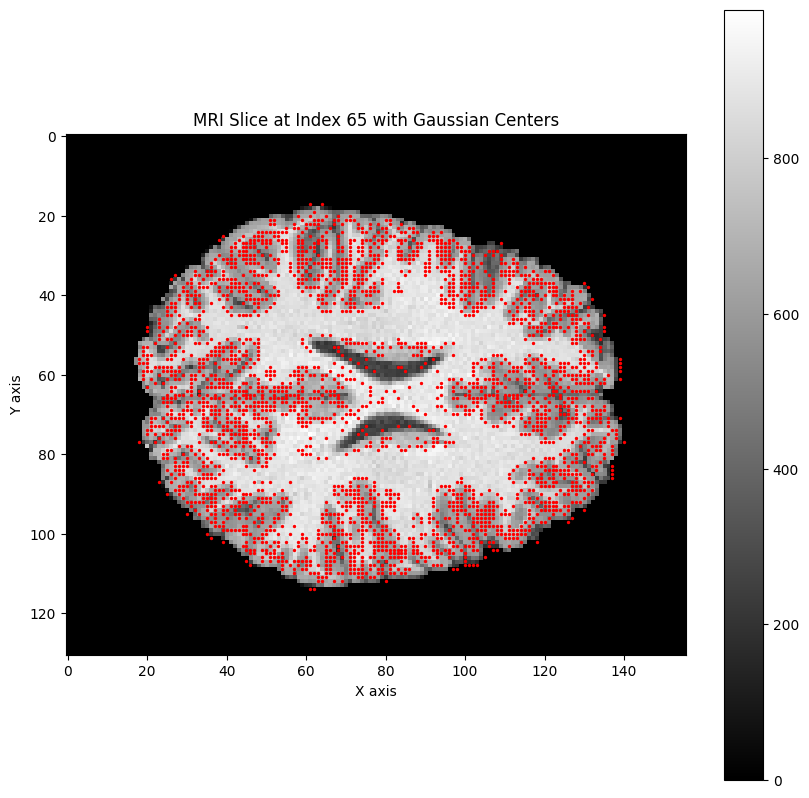

In [21]:
# Step 3: Find Gaussian Centers Based on Gradient Magnitude
# For simplicity, let's select points with gradient magnitude around the median as centers
median_grad = np.median(filtered_grad_magnitude[filtered_grad_magnitude > 0])
close_to_median = np.abs(filtered_grad_magnitude - median_grad) < (0.3 * median_grad)
gaussian_centers = np.argwhere(close_to_median)

# Choose a slice index for visualization, e.g., the middle slice along the z-axis
slice_index = mri_volume.shape[2] // 2
slice_image = mri_volume[:, :, slice_index]

# Filter Gaussian centers that are in this slice
centers_in_slice = [center for center in gaussian_centers if center[2] == slice_index]

# Plot the MRI slice
plt.figure(figsize=(10, 10))
plt.imshow(slice_image, cmap='gray')
plt.colorbar()
plt.title(f'MRI Slice at Index {slice_index} with Gaussian Centers')

# Plot Gaussian centers on the slice
for center in centers_in_slice:
    plt.scatter(center[1], center[0], color='red', s=2)  # Note: (x, y) coordinates are inverted in plt.scatter

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()


### Gaussian Centers Based on High Gradient Magnitude

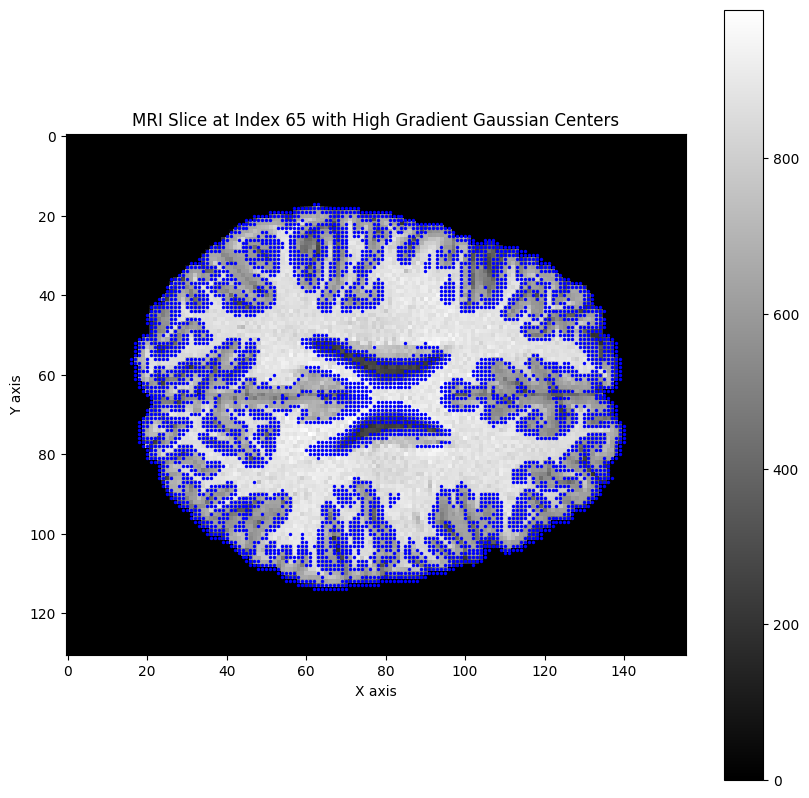

In [22]:
# Step 3 (Modified): Find Gaussian Centers Based on High Gradient Magnitude
# Define a high gradient threshold, for example, as the 90th percentile of the gradient magnitudes
high_grad_threshold = np.percentile(filtered_grad_magnitude[filtered_grad_magnitude > 0], 50)
high_gradient_points = np.where(filtered_grad_magnitude >= high_grad_threshold)

# Convert the high gradient points into a list of coordinates
gaussian_centers_high_grad = np.array(list(zip(*high_gradient_points)))

# Assuming we are still visualizing the same slice as before
# Filter Gaussian centers that are in this slice (for high gradient centers)
centers_in_slice_high_grad = [center for center in gaussian_centers_high_grad if center[2] == slice_index]

# Plot the MRI slice with high gradient Gaussian centers
plt.figure(figsize=(10, 10))
plt.imshow(slice_image, cmap='gray')
plt.colorbar()
plt.title(f'MRI Slice at Index {slice_index} with High Gradient Gaussian Centers')

# Plot high gradient Gaussian centers on the slice
for center in centers_in_slice_high_grad:
    plt.scatter(center[1], center[0], color='blue', s=2)  # Blue to differentiate from previous centers

plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()


### Calculate radius and intensity

In [ ]:
# For each center, calculate a simplistic radius and intensity (this part is highly simplified)
radii = np.empty(len(gaussian_centers))
intensities = np.empty(len(gaussian_centers))
for i, center in enumerate(gaussian_centers):
    # Simplified neighbor calculation and parameter initialization
    # Actual implementation should consider spatial distribution
    radii[i] = 1 / (1 + np.sum(close_to_median))  # Inversely proportional to number of centers
    intensities[i] = mri_volume[tuple(center)]  # Directly use voxel intensity

# This is a very basic approach; real applications might require more sophisticated methods